# Problem Set 4 - Atmospheric Inversion

## ATMS/ESS/OCEAN 588

Abigail L.S. Swann, original concept from Inez Fung

In this problem set we will explores the principal observations about the contemporary carbon cycle, and uses an atmospheric 2-box mixing model to infer the distribution of carbon sinks over the last few decades. 

This code  
Section 1. Defines parameters, Loads fossil fuel emission data, loads atmospheric CO2 observation data   
Section 2. Forward Integration of 2-box model   
Section 3. Inverse Calculation
Section 4. Additional Calculations

#### Load Python Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Section 1. Setup problem

## Define Parameters for PS4 here

In [2]:
#%%%% --- Define Parameters Here ---%%%

#%%%------>>>> Change Hemispheric Mixing time here!<<<<------%%%
#% interhemispheric exchange time (year).  Default = 1 year.
# suggested range to try [0.8, 1, 1.2, 1.5, 2] 
tau=1   

#%%%%----->>>> Change vertical gradient in CO2 here! <<<<-----%%%%
#% ratio of surface gradient to column mean gradient.  
# suggested range to try [1.0, 1.2, 1.5, 2]
gamma=1


#### Define Constants

In [3]:
#%-- Define Constants
#%---->>> NOTE: This unit coversion is defined for ONE HEMISPHERE <<<<----%%
#% 1 PgC into a single hemisphere --> 1 ppm
Pg2ppm_1h=1;  

### Load Data for Fossil Fuel Emissions
Fossil fuel emissions data that comes from the global carbon project. This is the most up to date dataset that I'm able to find.

The page that describes the data is here: https://doi.org/10.5281/zenodo.5569235 

The data contains emissions for all countries, and we will use the "global" values at the bottom of the file. 

Units are in Million Metric Tons of CO2, which we will need to convert to PgC (note difference in CO2 vs C!)



In [4]:
# attempt to load the global carbon project version of the data instead of the CDIAC TRENDS

dfEmissions = pd.read_csv('GCB2021v34_MtCO2_flat.csv', encoding='latin-1')

Extract data from the data structure

The data structre reads the header rows, so we can refence the columns by name. We want "Global" rows, and will extract "Year" and "Total" for emissions. 

You can also explore per capita emissions in this dataset, or look at specific countries.

In [5]:
# Select only rows for Global values (rather than a country) 
# You could modify this to find individual countries instead

dfGlobal = dfEmissions.loc[dfEmissions['Country']=="Global"]

# find the columns conatining data we want to look at 
year_FF = dfGlobal.Year.values
FFtotal_mtCO2= dfGlobal.Total.values

convert units of FF flux from million metric tons CO2 to Peta-grams C

million metric ton = 1e6 * 1e6 g/ton = 1e12 g CO2 
gC = 12g/mole , gCO2 = 12+16+16 = 44 g/mole

1gCO2* 12gC/44gCO2

In [6]:
# convert million tons of CO2 to PgC
FFtotal_PG = FFtotal_mtCO2*12/44*1e12/1e15

### Load data for Atmospheric CO$_2$ concentration from MLO and SPO
 Atmospheric CO2 concentration can be estimated from the observational 
 record at Mauna Loa Observatory (MLO) and South Pole Observatory (SPO)
 
 The data is available here, specifically we will use flask collected samples at monthly resolution (in PS1 we used annually averaged data): 
http://www.esrl.noaa.gov/gmd/dv/data/
 
 
 units are in mole fraction in dry air, micromol/mol, also called 
 parts per million - or ppm
 
 #### Load MLO

In [7]:
# Load data file (don't worry about the error message about regex)
df = pd.read_csv('co2_mlo_surface-flask_1_ccgg_month.txt', sep=r'\s{1,}', skiprows=71, engine='python')
datastruct = df.values

#---- Extract data from the data structure----
# This data set has 4 columns [StationName Year Month CO2] (and don't forget that python indexes from zero)
                                                           
year_MLO = datastruct[:,1]
month_MLO = datastruct[:,2]
MLO_monthly = datastruct[:,3]

MLO_time = year_MLO+month_MLO/12 - 1/24

# missing data points
missingMLO = np.where(np.diff(MLO_time)>(1/12+1/24))


#### Load SPO

In [8]:
# Load data file (don't worry about the error message about regex)
df = pd.read_csv('co2_spo_surface-flask_1_ccgg_month.txt', sep=r'\s{1,}', skiprows=71, engine='python')
datastruct = df.values

#---- Extract data from the data structure----
# This data set has 4 columns [StationName Year Month CO2] (and don't forget that python indexes from zero)
                                                           
year_SPO = datastruct[:,1]
month_SPO = datastruct[:,2]
SPO_monthly = datastruct[:,3]

SPO_time = year_SPO+ month_SPO/12 - 1/24

# missing data points
missingSPO = np.where(np.diff(SPO_time)>(1/12+1/24))

#### Calculate Annual Mean CO2 and find overlapping data

In [9]:
# Find common data period for fossil fuel emissions, MLO observations, and SPO observations

# -- this should be the startdate: startdate = int(np.ceil(np.max([year_FF[0],MLO_time[0],SPO_time[0]])))
# but there is missing data at SPO so we will start in 1981
startdate = int(1981)
enddate = int(np.floor(np.min([year_FF[-1],MLO_time[-1],SPO_time[-1]])))

# calculate an annual mean CO2 (for MLO this can be downloaded, but not for SPO, so we will calculate it ourselves)
MLO = np.empty(enddate-startdate+1,dtype=object) #initialize a list
SPO = np.empty(enddate-startdate+1,dtype=object) #initialize a list
years=range(startdate,enddate+1)

for yr in years:
    MLO[yr-startdate]= np.mean(MLO_monthly[np.where(year_MLO==yr)]) # average together all months in a year
    SPO[yr-startdate]= np.mean(SPO_monthly[np.where(year_SPO==yr)]) # average together all months in a year

    
# calculate the Hemispheric Difference in observations as MLO-SPO
HemisphericDifference=MLO-SPO


# subset fossil fuel data to same dates as CO2 data
FF = FFtotal_PG[np.where(np.logical_and(year_FF>=startdate,year_FF<=enddate))]


### Plot observed CO2

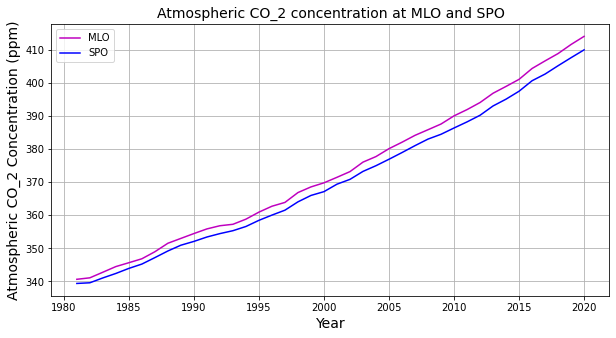

In [10]:
# make a new figure
fig = plt.figure(figsize=(10,5))
ax=plt.axes()

# plot 
ax.plot(years,MLO, color='m',label='MLO') 
ax.plot(years,SPO, color='b',label='SPO')

#ax.plot(SPO_time[commontimeindx], SPO_monthly[commontimeindx], color='b',label='SPO')

ax.legend()
plt.grid()

# set a title
plt.title('Atmospheric CO_2 concentration at MLO and SPO',fontsize=14,y=1)

# add axis labels
plt.ylabel('Atmospheric CO_2 Concentration (ppm)',fontsize=14)
plt.xlabel('Year',fontsize=14)

# show the plot:
plt.show()

# save the plot
fig.savefig('CO2.png', bbox_inches='tight')
#print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

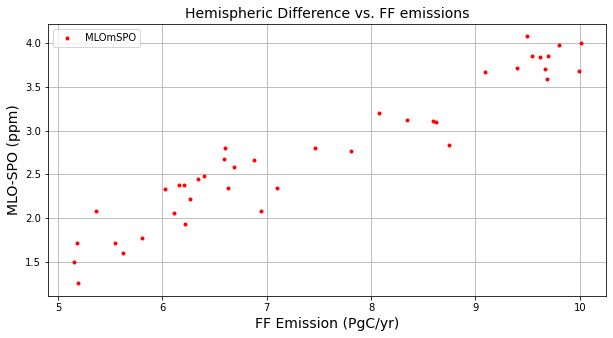

In [11]:
# make a new figure
fig = plt.figure(figsize=(10,5))
ax=plt.axes()

# plot a zonal mean on an existing figure axis
ax.plot(FF, HemisphericDifference, color='r',label='MLOmSPO', marker=".", linestyle="none")
#ax.plot(FFtotal_PG[np.where(np.logical_and(FF_year>=startdate,FF_year<=enddate))], SPO_monthly[np.where(np.logical_and(SPO_time>=startdate,SPO_time<=enddate))], color='b',label='SPO')

#ax.plot(SPO_time[commontimeindx], SPO_monthly[commontimeindx], color='b',label='SPO')

ax.legend()
plt.grid()

# set a title
plt.title('Hemispheric Difference vs. FF emissions',fontsize=14,y=1)

# add axis labels
plt.ylabel('MLO-SPO (ppm)',fontsize=14)
plt.xlabel('FF Emission (PgC/yr)',fontsize=14)

# show the plot:
plt.show()

# save the plot
fig.savefig('MLOmSPOvsFF.png', bbox_inches='tight')
#print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

## Section 2. Forward Integration of 2-Box Model

Forward Integration of 2-Box Model.  FF CO2: 100% airborne 

Two Box Model of Hemispheric Mixing in the Atmosphere  
     
$\frac{d}{dt}(M_n)= -\frac{(M_n-M_s)}{\tau} + S_n$  
     
$\frac{d}{dt}(M_s)= \frac{(M_n-M_s)}{\tau} + S_s$  

In [12]:
#%-- Define integration parameters
Nstepsperyr=100     
dt=1/Nstepsperyr    #% time step (year)

#%-- Assume all fossil fuel is emitted in the Northern Hemisphere
Ss=0;      

#%-- Interpolate FF emissions to the time integrated grid
FF_interp = np.interp(np.linspace(years[0],years[-1],Nstepsperyr*(enddate-startdate)),years,FF)

#%%%%%%%%% Integrate from 1980 onwards.  Initialize with observations for 1980.
mnlast=MLO[0]/(Pg2ppm_1h*gamma)  
mslast=SPO[0]/(Pg2ppm_1h*gamma)

mn = np.empty(Nstepsperyr,dtype=object) #initialize a list
ms = np.empty(Nstepsperyr,dtype=object) #initialize a list
Mn = np.empty(enddate-startdate+1,dtype=object) #initialize a list
Ms = np.empty(enddate-startdate+1,dtype=object) #initialize a list
for ny in range(enddate-startdate+1):
    #%Sn=ff(ny);        % should interpolate annaul emission between years.  too lazy.
    for ns in range(Nstepsperyr):
        Sn = FF_interp[(ny-1)*Nstepsperyr+ns]
        mn[ns]=mnlast - dt*(mnlast-mslast)/tau + dt*Sn
        ms[ns]=mslast + dt*(mnlast-mslast)/tau + dt*Ss
        mnlast=mn[ns]
        mslast=ms[ns]

    Mn[ny] = np.mean(mn[0:Nstepsperyr])   #% annual mean
    Ms[ny] = np.mean(ms[0:Nstepsperyr])


#% Mass difference, 100% airborne
hemdiff100 = Mn-Ms        

#% gamma=sfc gradient/column avg gradient; 
dppm100 = hemdiff100*Pg2ppm_1h*gamma     


#### Plot - compare observed gradient to predicted gradient with 100% Airborne Fraction of FF Emissions

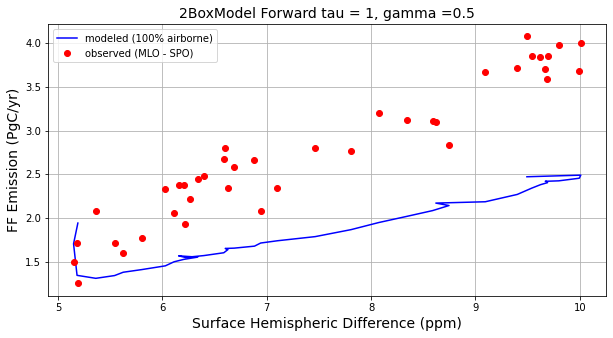

In [13]:
#%%%% Compare observed gradient to predicted gradient with 100%
           
# make a new figure
fig = plt.figure(figsize=(10,5))
ax=plt.axes()

# plot 
ax.plot(FF, dppm100, color='b',label='modeled (100% airborne)') #, marker=".", linestyle="none")
ax.plot(FF, HemisphericDifference, color='r',label='observed (MLO - SPO)', marker="o", linestyle="none")

ax.legend()
plt.grid()

# set a title
plt.title('2BoxModel Forward tau = ' +str(tau) +', gamma =' +str(gamma),fontsize=14,y=1)

# add axis labels
plt.xlabel('FF Emission (PgC/yr)',fontsize=14)
plt.ylabel('Surface Hemispheric Difference (ppm)',fontsize=14)

# show the plot:
plt.show()

filename = '2BoxModelForward_100airborne_tau_' +str(tau) +'_gamma_' +str(gamma) +'.png'

# save the plot
fig.savefig(filename, bbox_inches='tight')
#print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

## Seciton 3. Inverse Calculation

"Inverse":  What are the sinks needed to match the observed gradient?   


Rewriting the 2-box equations:  
$S_n = FF - L_n =  \frac{d}{dt}(M_n) + \frac{(M_n-M_s)}{\tau} $  
$S_s =  0 - L_s =  \frac{d}{dt}(M_s) - \frac{(M_n-M_s)}{\tau} $  
    
Ln, Ls are the losses (sinks) in the NH and SH, resp.    
We assume that all FF is emitted in the NH => Ps = 0  
    
Note that we are no longer assuming steady state. Need to estimate d/dt terms

$M_n = \gamma MLO_{obs}$  
$M_s = \gamma SPO_{obs}$  

In [14]:

dtyr=1   #% this is the time step between MLO and SPO obs, not the interhem exchange time

Mnobs=MLO/(gamma*Pg2ppm_1h) 
Msobs=SPO/(gamma*Pg2ppm_1h)

#ddtMn = np.empty(enddate-startdate+1,dtype=object) #initialize a list
#ddtMs = np.empty(enddate-startdate+1,dtype=object) #initialize a list

ddtMn = np.insert(np.diff(Mnobs)/dtyr,0,0)
ddtMs = np.insert(np.diff(Msobs)/dtyr,0,0)


Ln = FF - ddtMn - (Mnobs-Msobs)/tau
Ls =    - ddtMs + (Mnobs-Msobs)/tau


#### Plots

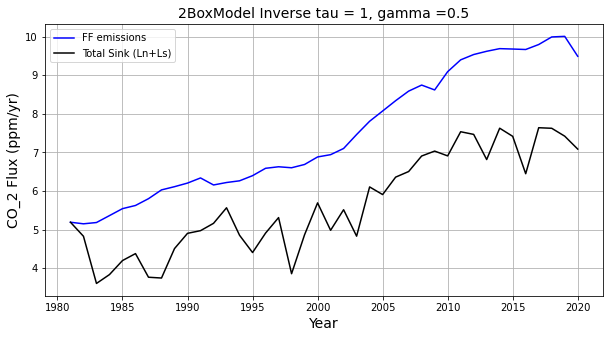

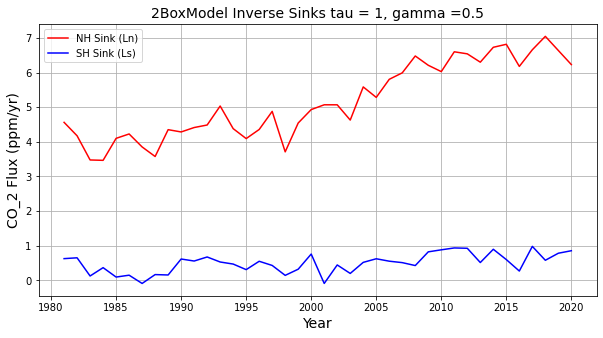

In [15]:
# make a new figure
fig = plt.figure(figsize=(10,5))
ax=plt.axes()

# plot 
ax.plot(years, FF, color='b',label='FF emissions')
ax.plot(years, Ln+Ls, color='k',label='Total Sink (Ln+Ls)')

ax.legend()
plt.grid()

# set a title
plt.title('2BoxModel Inverse tau = ' +str(tau) +', gamma =' +str(gamma),fontsize=14,y=1)

# add axis labels
plt.ylabel('CO_2 Flux (ppm/yr)',fontsize=14)
plt.xlabel('Year',fontsize=14)

# show the plot:
plt.show()

filename = '2BoxModelInverse_tau_' +str(tau) +'_gamma_' +str(gamma) +'.png'

# save the plot
fig.savefig(filename, bbox_inches='tight')
#print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()



######



# make a new figure
fig = plt.figure(figsize=(10,5))
ax=plt.axes()

# plot 
ax.plot(years, Ln, color='r',label='NH Sink (Ln)')
ax.plot(years, Ls, color='b',label='SH Sink (Ls)')

ax.legend()
plt.grid()

# set a title
plt.title('2BoxModel Inverse Sinks tau = ' +str(tau) +', gamma =' +str(gamma),fontsize=14,y=1)

# add axis labels
plt.ylabel('CO_2 Flux (ppm/yr)',fontsize=14)
plt.xlabel('Year',fontsize=14)

# show the plot:
plt.show()

filename = 'Sink_timeseries_tau_' +str(tau) +'_gamma_' +str(gamma) +'.png'

# save the plot
fig.savefig(filename, bbox_inches='tight')
#print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()


## Section 4. Additional Calculations

In [16]:
print('Cumulative Sinks and FF emissions for the period ' +str(startdate) +' to ' +str(enddate))

#to calculate the cumulative sinks or FF emissions you can use the function np.sum

cumulativeSink_Pg = round(np.sum(Ln+Ls),2)
print('Cumulative Sink in Pg (also called Total Sink) = ' +str(cumulativeSink_Pg) +' PgC')

cumulativeFFemissions_Pg = round(np.sum(FF),2)
print('Cumulative Fossil Fuel Emissions in Pg = ' +str(cumulativeFFemissions_Pg) +' PgC')

print('Estimates for sink in the NH for tau=' +str(tau) +', gamma=' +str(gamma) +':')

cumulativeNHSink_Pg = round(np.sum(Ln),2)
print('Cumulative NH Sink in Pg = ' +str(cumulativeNHSink_Pg) +' PgC')

TotalSinkpercentOfFFemissions=round(100*cumulativeSink_Pg/cumulativeFFemissions_Pg,2)
print('Total cumulative sink as a percent of total FF emissions = ' +str(TotalSinkpercentOfFFemissions) +' %')

NHpercentOfTotalSink=round(100*cumulativeNHSink_Pg/cumulativeSink_Pg,2)
print('Percent of Total cumulative sink that went into the NH = ' +str(NHpercentOfTotalSink) +' %')

Cumulative Sinks and FF emissions for the period 1981 to 2020
Cumulative Sink in Pg (also called Total Sink) = 226.63 PgC
Cumulative Fossil Fuel Emissions in Pg = 298.62 PgC
Estimates for sink in the NH for tau=1, gamma=0.5:
Cumulative NH Sink in Pg = 206.81 PgC
Total cumulative sink as a percent of total FF emissions = 75.89 %
Percent of Total cumulative sink that went into the NH = 91.25 %
